# UEP-0239 Homework Assignment 7

In this assignment we will practice raster analysis by conducting a risk assessment, which has a workflow nearly identical to a suitability analysis. The assignment is largely based on [this tutorial](https://sites.tufts.edu/gis/files/2013/11/RiskAssessment_MalariaInEthiopia_tutorial_10.6.1.pdf) written by Carolyn Talmadge for the [Tufts Data Lab](https://sites.tufts.edu/datalab/). The tutorial walks through a similar analysis using ArcGIS Desktop (also known as ArcMap). Your mission is to translate parts of the analysis into Python code utilizing open-source libraries as instructed below.

## README 

- **Name:** Kameice Francis
- **Number of hours:** ~6 
- I went to Chris' and Kyle's Office Hours to get help with this assignment. I also spoke with Uku. 


## Introduction

Malaria is a serious acute illness transmitted via the bite of a mosquito. Symptoms include fever, headache, backache, joint pains, and vomiting. If not treated, malaria can quickly become life-threatening. According to the World Health Organization (WHO), roughly 75% of the land and 60% of the population is exposed to malaria in Ethiopia. The purpose of this analysis is to determine the overall risk of Malaria transmission throughout Ethiopia, considering the following factors:

- **Proximity to rivers** – Malaria is a water-related disease because it is transmitted via mosquitos who prefer to breed near rivers. Therefore, proximity to rivers results in higher risk of transmission.
- **Elevation** – Elevation is directly linked to climate, and mosquitos prefer warmer climates and lower elevations. Lower elevations increase mosquito population turnover, which means a higher risk of transmission.
- **Slope** – Gentle slopes equal higher susceptible areas for malaria incidence.
- **Land cover** – Mosquitos prefer damp areas, so land cover will affect the analysis.

## The Data

The `data` folder in your assignment repository should contain the following files:

- `data/boundaries/ethiopia.shp` – the boundaries of Ethiopia (ESRI shapefile)
- `data/boundaries/zones.shp` – boundaries of second-order administrative zones (ESRI shapefile)
- `data/elevation/elevation.tif` - digital elevation model (DEM) of Ethiopia and surrounding areas (GeoTIFF)
- `data/landcover/landcover.tif` - land cover raster for Ethiopia and surrounding areas (GeoTiFF)
- `data/water/rivers.shp` – rivers of Ethiopia (ESRI Shapefile)

To make your analysis simpler, the `elevation.tif` and `landcover.tif` rasters have been clipped to the same extent with matching resolutions and all data has been projected to the [ESRI:102022 Africa Alberts Equal Area Conic](https://spatialreference.org/ref/esri/africa-albers-equal-area-conic/) projection.

## Analysis Overview

Here is a rough outline of the analysis we will perform:

1. Read in and visualize the raster datasets (10 pts)
2. **Land cover** > reclassify for land cover preferences (10 pts)
3. **Elevation (DEM)** > derive slope > reclassify for slope preferences (low slope = high risk) (20 pts)
4. **Elevation (DEM)** > reclassify for elevation preferences (low elevation = high risk) (10 pts)
5. **Rivers** > rasterize shapefile > get euclidean distance raster > reclassify (close = high risk) (25 pts)
6. Calculate weighted and unweighted risk raster from all reclassified rasters (5 pts)
7. Mask risk rasters to the shape of Ethiopia (10 pts)
8. **Extra credit:** Use zonal statistics to determine average risk per zone (20 pts)


## Import Dependencies

Here are some dependency imports to get you started. Feel free to add more import statements if needed.

In [1]:
import rasterio
from rasterio.plot import show
from rasterio import features

import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

import richdem as rd
from scipy import ndimage
from rasterstats import zonal_stats

## Read Raster Datasets (5 pts)

Use [`rasterio.open()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) to open and read in both the elevation and landcover datasets. Remember that just like the [`open()`](https://docs.python.org/3/library/functions.html#open) function in Python, this function establishes a connection to the file, which should later be closed. Hence, you should either use [`with`](https://docs.python.org/3/reference/compound_stmts.html#with) to open the file and extract all relevant information or make sure to use [`.close()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.close) to close the connection once you are done.

It is also important to remember that the [`rasterio.open()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.html#rasterio.open) function returns a [`DatasetReader`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader) object, not the dataset itself. However, the [`DatasetReader`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader) object has numerous attributes and methods that allow you to read in various components of the raster dataset. For example, you can use the [`.meta`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.meta) attribute to access the metadata associated with the raster and you can use the [`.read()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.read) method to extract the raster data values as a matrix.

Both raster datasets should have the same coordinate system, extent, and resolution, but you should use the [`.meta`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.meta) attribute to compare the metadata for both files and ensure this is the case.

Once you have confirmed that the spatial attributes of both rasters are the same, use the [`.read()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.read) method with the appropriate band number to save the data matrices of the raster datasets into variables named `elevation` and `landcover`. Then pick one raster and use the appropriate attributes to extract all necessary spatial information into corresponding variables as well. Here is the information that is vital to the analysis:

- [`bounds`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.bounds) – the spatial extent of the rasters
- [`crs`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.crs) – the coordinate system used
- [`nodata`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.nodata) – the nodata value used (do this for each raster if the nodata values do not match)
- [`shape`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.shape) – number of rows and columns
- [`transform`](https://rasterio.readthedocs.io/en/latest/api/rasterio.io.html#rasterio.io.DatasetReader.transform) – how to translate from row/column indices to spatial coordinates

Make sure to explore both the data matrices and the various metadata values once you have extracted them to ensure everything is as expected.

In [2]:
#opening and reading in the elevation dataset
elev = rasterio.open("data\elevation\elevation.tif")

In [3]:
#opening and reading in the landcover dataset
land = rasterio.open("C:data\landcover\landcover.tif")

In [4]:
#checking the data type of the variable that was created from the elevation dataset
type(elev)

rasterio.io.DatasetReader

In [5]:
#checking the data type of the variable that was created from the landcover dataset
type(land)

rasterio.io.DatasetReader

In [6]:
#looking at the metadata for elev (elevation variable)
elev.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 1557,
 'height': 1336,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(1000.0, 0.0, 832212.046055039,
        0.0, -1000.0, 1734510.2316801762)}

In [7]:
#looking at the metadata for land (landcover variable)
land.meta

{'driver': 'GTiff',
 'dtype': 'int16',
 'nodata': -32768.0,
 'width': 1557,
 'height': 1336,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(1000.0, 0.0, 832212.046055039,
        0.0, -1000.0, 1734510.2316801762)}

In [8]:
#saving the data matrices of the elevation raster dataset into a variable named elevation 
elevation = elev.read(1)

In [9]:
#saving the data matrices of the landcover raster dataset into a variable named landcover
landcover = land.read(1)

In [10]:
#looking at the elevation variable
elevation[0]

array([ 399,  397,  392, ..., 1380, 1395, 1391], dtype=int16)

In [11]:
#saving the resolution for the elevation dataset 
res = elev.res
res

(1000.0, 1000.0)

In [12]:
#getting information about the spatial extent of the rasters and putting it into a variable (only need to use one since both have the same res etc.)
ele_bounds = elev.bounds
ele_bounds

BoundingBox(left=832212.046055039, bottom=398510.2316801762, right=2389212.046055039, top=1734510.2316801762)

In [13]:
#getting information about the crs of the rasters and putting it into a variable
ele_crs = elev.crs
ele_crs

CRS.from_wkt('PROJCS["Africa_Albers_Equal_Area_Conic",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",0],PARAMETER["longitude_of_center",25],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",-23],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [14]:
#getting information about the nodata value used by each raster and putting it into a variable
ele_nodata = elev.nodata
ele_nodata

-32768.0

In [15]:
#getting information about the nodata value used by each raster and putting it into a variable
land_nodata = land.nodata
land_nodata

-32768.0

In [16]:
#getting information about the number of rows and columns in each raster and putting it into a variable
ele_shape = elev.shape
ele_shape

(1336, 1557)

In [17]:
#getting information about how to translate from row/column indices to spatial coordinates and putting it into a variable
ele_transform = elev.transform
ele_transform

Affine(1000.0, 0.0, 832212.046055039,
       0.0, -1000.0, 1734510.2316801762)

In [18]:
elev.close()

In [19]:
land.close()

## Reclassify Land Cover (10 pts)

Although the land cover raster contains numeric data, each number is representative of a land cover type. This information is usually stored in the raster attribute table accompanying the raster. The land cover raster we are using also has an accompanying raster attribute table, but unfortunately RasterIO is not yet able to read raster attribute tables. Hence, you have to use the table below to map the numerical cell values to their corresponding land cover types.

| Cell Value | Land Cover                       |
| :--------: | -------------------------------- |
|      0     | Water                            |
|      1     | Evergreen Needleleaf Forest      |
|      2     | Evergreen Broadleaf Forest       |
|      3     | Deciduous Needleleaf Forest      |
|      4     | Deciduous Broadleaf Forest       |
|      5     | Mixed Forests                    |
|      6     | Closed Shrublands                |
|      7     | Open Shrublands                  |
|      8     | Woody Savannas                   |
|      9     | Savannas                         |
|     10     | Grasslands                       |
|     11     | Permanent Wetlands               |
|     12     | Croplands                        |
|     13     | Urban and Built-Up Areas         |
|     14     | Cropland with Natural Vegetation |
|     15     | Snow and Ice                     |
|     16     | Barren or Sparsely Vegetated     |


We would like to assign a risk score ranging from one to five (with one denoting lowest risk and five denoting highest risk) to each of the land cover types as specified below.

| Land Cover Types                     | Land Cover Codes  | Risk Level     | Risk Score |
| ------------------------------------ | ----------------- | -------------- | :--------: |
| Water and Wetlands                   | 0, 11             | Very high risk |      5     |
| Croplands and Natural Vegetation     | 12, 14            | High risk      |      4     |
| Shrublands, Grasslands, and Savannas | 6, 7, 8, 9, 10    | Medium risk    |      3     |
| Forests and Urban/Built-Up Areas     | 1, 2, 3, 4, 5, 13 | Low risk       |      2     |
| Snow/Ice and Barren Land             | 15, 16            | Very low risk  |      1     |


Create a reclassified land cover raster as follows:
1. Use [`np.full()`](https://numpy.org/doc/stable/reference/generated/numpy.full.html) to create an empty array filled with `np.NaN` that matches the `shape` of the land cover raster.
2. Utilize [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to fill the newly created raster based on values of the `landcover` data matrix.

Once you have created the reclassified land cover raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

## Visualize the Raster Datasets (5 pts)

Use the RasterIO [`show()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show) function to visualize both raster datasets and ensure they were read in correctly. Make sure to specify the `transform` to see actual spatial coordinates on the axes. Also use the `cmap` attribute to specify appropriate [Matplotlib colormaps](https://matplotlib.org/stable/tutorials/colors/colormaps.html) for each dataset. Remember that land cover data is categorical, so you should use a categorical color map for that visualization.

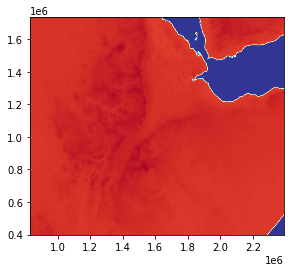

In [60]:
#visualised the elevation raster dataset and ensuring that it was read in correctly 
show(elevation, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

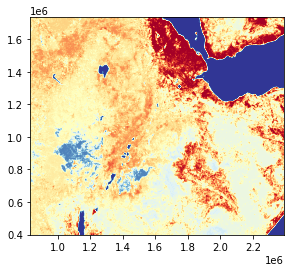

In [61]:
#visualised the landcover raster dataset and ensuring that it was read in correctly 
show(landcover, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Reclassify Land Cover (10 pts)

Although the land cover raster contains numeric data, each number is representative of a land cover type. This information is usually stored in the raster attribute table accompanying the raster. The land cover raster we are using also has an accompanying raster attribute table, but unfortunately RasterIO is not yet able to read raster attribute tables. Hence, you have to use the table below to map the numerical cell values to their corresponding land cover types.

| Cell Value | Land Cover                       |
| :--------: | -------------------------------- |
|      0     | Water                            |
|      1     | Evergreen Needleleaf Forest      |
|      2     | Evergreen Broadleaf Forest       |
|      3     | Deciduous Needleleaf Forest      |
|      4     | Deciduous Broadleaf Forest       |
|      5     | Mixed Forests                    |
|      6     | Closed Shrublands                |
|      7     | Open Shrublands                  |
|      8     | Woody Savannas                   |
|      9     | Savannas                         |
|     10     | Grasslands                       |
|     11     | Permanent Wetlands               |
|     12     | Croplands                        |
|     13     | Urban and Built-Up Areas         |
|     14     | Cropland with Natural Vegetation |
|     15     | Snow and Ice                     |
|     16     | Barren or Sparsely Vegetated     |


We would like to assign a risk score ranging from one to five (with one denoting lowest risk and five denoting highest risk) to each of the land cover types as specified below.

| Land Cover Types                     | Land Cover Codes  | Risk Level     | Risk Score |
| ------------------------------------ | ----------------- | -------------- | :--------: |
| Water and Wetlands                   | 0, 11             | Very high risk |      5     |
| Croplands and Natural Vegetation     | 12, 14            | High risk      |      4     |
| Shrublands, Grasslands, and Savannas | 6, 7, 8, 9, 10    | Medium risk    |      3     |
| Forests and Urban/Built-Up Areas     | 1, 2, 3, 4, 5, 13 | Low risk       |      2     |
| Snow/Ice and Barren Land             | 15, 16            | Very low risk  |      1     |


Create a reclassified land cover raster as follows:
1. Use [`np.full()`](https://numpy.org/doc/stable/reference/generated/numpy.full.html) to create an empty array filled with `np.NaN` that matches the `shape` of the land cover raster.
2. Utilize [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to fill the newly created raster based on values of the `landcover` data matrix.

Once you have created the reclassified land cover raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [62]:
#create an empty array filled with np.NaN that matches the shape of the land cover raster.
land_reclass = np.full(ele_shape, np.NaN)

In [63]:
#Utilizing boolean indexing to fill the newly created raster based on values of the landcover data matrix 
land_reclass[(landcover==0) | (landcover == 11)] = 5
land_reclass[(landcover== 12) | (landcover == 14)] = 4
land_reclass[(landcover == 6) | (landcover == 7) | (landcover == 8) | (landcover == 9) | (landcover == 10)] = 3
land_reclass[(landcover == 1) | (landcover == 2) | (landcover == 3) | (landcover == 4) | (landcover == 5) | (landcover == 13)] = 2
land_reclass[(landcover == 15) | (landcover == 16)] = 5

In [64]:
land_reclass

array([[3., 3., 3., ..., 5., 3., 5.],
       [3., 3., 3., ..., 5., 5., 5.],
       [3., 5., 3., ..., 3., 5., 5.],
       ...,
       [3., 3., 3., ..., 5., 5., 5.],
       [3., 3., 3., ..., 5., 5., 5.],
       [3., 3., 3., ..., 5., 5., 5.]])

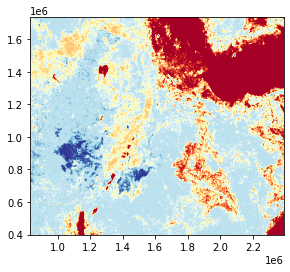

In [65]:
#visualising the reclassified land cover raster
show(land_reclass, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Calculate Slope Raster (10 pts)

Use [RichDEM](https://richdem.readthedocs.io/en/latest/) to calculate a slope raster as follows:
1. Use `rd.rdarray()` to create an `rdarray` version of the `elevation` matrix. Make sure to specify the appropriate `no_data` value!
2. Use `.to_gdal()` to convert the `transform` to the format expected by RichDEM and set that as the `.geotransform` attribute of the new `rdarray`.
3. Use [`rd.TerrainAttribute()`](https://richdem.readthedocs.io/en/latest/python_api.html#richdem.TerrainAttribute) to calculate the `"slope_percentage"` attribute.

Note that the values of the result matrix are slope percentages, meaning that they range from zero to one hundred. Make sure to take a look at the data matrix and visualize it using [`show()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.plot.html#rasterio.plot.show) to validate your work.

In [26]:
#Use rd.rdarray() to create an rdarray version of the elevation matrix (using the elevation nodata value)
elev_rd = rd.rdarray(elevation, no_data=ele_nodata)

In [27]:
#Using .to_gdal() to convert the transform to the format expected by RichDEM and set that as the .geotransform attribute of the new rdarray.
elev_rd.geotransform = ele_transform.to_gdal()

In [28]:
#Using rd.TerrainAttribute() to calculate the "slope_percentage" attribute
slope = rd.TerrainAttribute(elev_rd, attrib='slope_percentage')

In [29]:
#checking the max slope percentage attribute
slope.max()

rdarray(63.547405, dtype=float32)

In [30]:
#checking the slope percentage attribute
slope

rdarray([[ 2.1213204e-01,  1.6007811e-01,  3.6912057e-01, ...,
           1.8915932e+00,  1.5366360e+00,  1.6554834e+00],
         [ 3.9528470e-02,  2.7669930e-01,  2.7950850e-01, ...,
           1.7201926e+00,  1.7804494e+00,  2.1396554e+00],
         [ 4.5069391e-01,  2.6925823e-01,  2.2150056e-01, ...,
           4.0630193e+00,  4.8939376e+00,  4.1506400e+00],
         ...,
         [ 1.0700468e+00,  6.6918796e-01,  3.7500000e-01, ...,
          -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
         [ 4.8088461e-01,  7.1959192e-01,  8.7927526e-01, ...,
          -9.9990000e+03, -9.9990000e+03, -9.9990000e+03],
         [ 1.3550830e+00,  1.0125772e+00,  6.5693414e-01, ...,
          -9.9990000e+03, -9.9990000e+03, -9.9990000e+03]], dtype=float32)

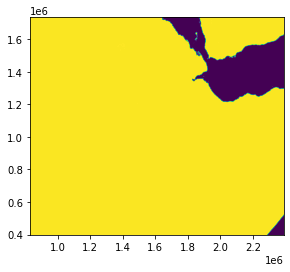

In [31]:
#visualising the data matrix using show
show(slope, transform=ele_transform)
plt.show()

## Reclassify Slope Raster (10 pts)

Create a reclassified slope raster as follows:
1. Use [`np.full()`](https://numpy.org/doc/stable/reference/generated/numpy.full.html) to create an empty array filled with `np.NaN` that matches the `shape` of the slope raster.
2. Utilize [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to fill the newly created raster based on the following slope values.

| Min Slope (Inclusive) | Max Slope (Exclusive) |   Risk Level   | Risk Score |
| :-------------------: | :-------------------: | :------------: | :--------: |
|          ...          |           2%          | Very high risk |      5     |
|           2%          |           5%          |    High risk   |      4     |
|           5%          |          12%          |   Medium risk  |      3     |
|          12%          |          20%          |    Low risk    |      2     |
|          20%          |          ...          |  Very low risk |      1     |


Note that you will be repeating a similar workflow to reclassify other rasters numerous times. If you are up for the challenge, attempt to write a function for the reclassification procedure that will allow you to automate further reclassification attempts. Once you have created the reclassified slope raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [32]:
#using np.full() to create an empty array filled with np.NaN that matches the shape of the slope raster.
slope_reclass = np.full(ele_shape, np.NaN)

In [33]:
#Using boolean indexing to fill the newly created raster based on the following slope values.
slope_reclass[(slope > 0) & (slope <= 2)] = 5
slope_reclass[(slope > 2) & (slope <= 5)] = 4
slope_reclass[(slope > 5) & (slope <= 12)] = 3
slope_reclass[(slope > 12) & (slope <= 20)] = 2
slope_reclass[slope > 20] = 1

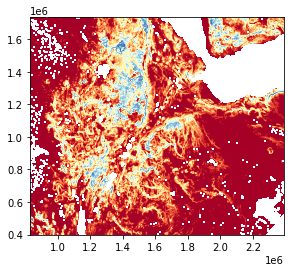

In [34]:
#visualising the reclassified slope raster using show
show(slope_reclass, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Reclassify Elevation Raster (10 pts)

Create a reclassified elevation raster based on the following elevation values.

| Min Elevation (Inclusive) | Max Elevation (Exclusive) |   Risk Level   | Risk Score |
| :-----------------------: | :-----------------------: | :------------: | :--------: |
|            ...            |             0             | Very high risk |      5     |
|             0             |            500            |    High risk   |      4     |
|            500            |            1200           |   Medium risk  |      3     |
|            1200           |            3000           |    Low risk    |      2     |
|            3000           |            ...            |  Very low risk |      1     |


Once you have created the reclassified land elevation raster, visualize it with using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [35]:
#using np.full() to create an empty array filled with np.NaN that matches the shape of the elevation raster.
elev_reclass = np.full(ele_shape, np.NaN)

In [36]:
#Using boolean indexing to fill the newly created raster based on the following slope values.
elev_reclass[(elevation > 0)] = 5
elev_reclass[(elevation > 0) & (elevation <= 500)] = 4
elev_reclass[(elevation > 500) & (elevation <= 1200)] = 3
elev_reclass[(elevation > 1200) & (elevation <= 3000)] = 2
elev_reclass[elevation > 3000] = 1

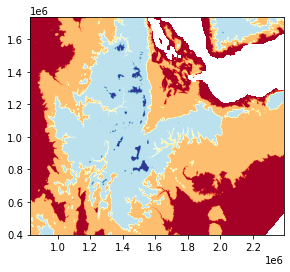

In [37]:
#visualising the reclassified elevation raster using show
show(elev_reclass, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Read in and Rasterize River Shapefile (10 pts)

We could like to consider distance to rivers in our analysis. To do so, we must first calculate an euclidean distance raster where the value of each cell is the distance to the nearest river from that cell. To do so, we must first read in and rasterize the river shapefile as follows:

1. Use [`gpd.read_file()`](https://geopandas.org/docs/reference/api/geopandas.read_file.html#geopandas.read_file) to read in the rivers shapefile.
2. Use [`features.rasterize()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize) from RasterIO to convert the river shapefile into a binary raster where zero denotes a river and one denotes the lack of a river.
    - Note that you should use the `"geometry"` column from the rivers GeoDataFrame as input.
    - Remember to specify the appropriate `transform`.
    - Use `default_value` to specify the value that should denote the presence of a river (0).
    - Use `fill` to specify the value that should denote the lack of a river (1).
    
Visualize both the shapefile and the raster to make sure the conversion worked as expected. If you have a hard time seeing the river pixels of the raster, use the `"flag"` colormap to bring them out more.

In [38]:
#Using gpd.read_file() to read in the rivers shapefile.
rivers = gpd.read_file('./data/water/rivers.shp')

In [39]:
#checking the information in the shapefile
rivers.head()

,osm_id,name,type,width,geometry
0,8036035,None,river,0,"LINESTRING (1150575.121 570853.647, 1150805.67..."
1,22763801,None,river,0,"LINESTRING (1449789.612 944897.478, 1450003.59..."
2,23409657,None,stream,0,"LINESTRING (1727520.584 1296850.102, 1727558.8..."
3,24259902,None,river,0,"LINESTRING (1441193.600 1051699.417, 1441189.4..."
4,24299073,Kebena,river,0,"LINESTRING (1434262.166 1057608.628, 1434257.2..."


In [40]:
#Using features.rasterize() from RasterIO to convert the river shapefile into a binary raster where zero denotes a river and one denotes the lack of a river.
riv_raster = features.rasterize(rivers['geometry'], out_shape=ele_shape, fill=1, transform=ele_transform, default_value=0)

In [41]:
riv_raster

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

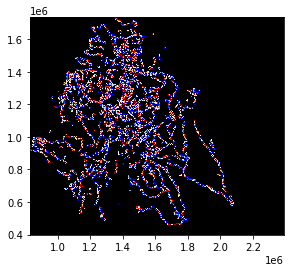

In [42]:
#Visualizing the rivers raster to make sure the conversion worked as expected
show(riv_raster, transform=ele_transform, cmap='flag')
plt.show()

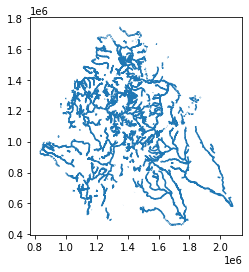

In [43]:
#Visualizing the rivers shapefile to make sure the conversion worked as expected
rivers.plot()
plt.show()

## Calculate Euclidean Distance Raster (5 pts)

Now we are ready to create an euclidean distance matrix that denotes distances to the nearest river. This is a relatively simple two-step process:
1. Use [`ndimage.distance_transform_edt()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.ndimage.distance_transform_edt.html) from SciPy to calculate the euclidean distance transform for the binary rivers raster.
2. Multiply the distance transform raster with the raster cell size (width or length) to convert the distances from number of cells to spatial units.
    - The `res` attribute you saved earlier should contain the dimensions of the square raster cell.
    
Note that this workflow assumes the raster to have square cells, which is the case for us. Once completed, visualize the distance raster to validate your work.

In [44]:
#Using ndimage.distance_transform_edt() from SciPy to calculate the euclidean distance transform for the binary rivers raster.
nearest_river = ndimage.distance_transform_edt(riv_raster) * res[0]

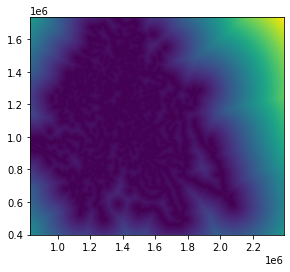

In [45]:
#visualising the distance raster (nearest_river) to validate work
show(nearest_river, transform=ele_transform)
plt.show()

## Reclassify Distance Raster (10 pts)

Create a reclassified river distance raster based on the following distance values. Remember that the distance values are in meters!

| Min Distance (Inclusive) | Max Distance (Exclusive) |   Risk Level   | Risk Score |
| :----------------------: | :----------------------: | :------------: | :--------: |
|            ...           |      1 mile (1609 m)     | Very high risk |      5     |
|      1 mile (1609 m)     |     5 miles (8046 m)     |    High risk   |      4     |
|     5 miles (8046 m)     |    25 miles (40233 m)    |   Medium risk  |      3     |
|    25 miles (40233 m)    |    75 miles (120701 m)   |    Low risk    |      2     |
|    75 miles (120701 m)   |            ...           |  Very low risk |      1     |


Once you have created the reclassified distance raster, visualize it using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [46]:
#reclassifying the river distance raster 
riv_reclass = np.full(ele_shape, np.NaN)
riv_reclass[nearest_river <= 1609] = 5
riv_reclass[(nearest_river > 1609) & (nearest_river <= 8046)] = 4
riv_reclass[(nearest_river > 8046) & (nearest_river <= 40233)] = 3
riv_reclass[(nearest_river > 40233) & (nearest_river <= 120701)] = 2
riv_reclass[nearest_river > 120701] = 1

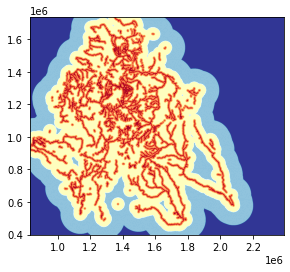

In [47]:
#visualizing the reclassified distance raster using the appropriate transform and the "RdYlBu_r" (reversed red-yellow-blue) colormap.
show(riv_reclass, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Calculate Weighted and Unweighted Risk Rasters (5 pts)

Create and visualize both a weighted and an unweighted risk raster. For the unweighed risk raster, just add up all the reclassified rasters. For the weighted risk raster, assign the following weights to each component.

| Component          | Weight |
| ------------------ | :----: |
| Distance to rivers |   35%  |
| Land cover         |   25%  |
| Slope              |   25%  |
| Elevation          |   15%  |

When visualizing the rasters, use the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap as before.

In [48]:
#unweighted risk raster
risk_raster = slope_reclass + riv_reclass + elev_reclass + land_reclass

In [49]:
#checking the unweighted risk raster
risk_raster

array([[13., 13., 13., ..., 13., 11., 13.],
       [13., 13., 13., ..., 13., 13., 12.],
       [13., 15., 13., ..., 10., 12., 12.],
       ...,
       [12., 12., 12., ..., nan, nan, nan],
       [12., 12., 12., ..., nan, nan, nan],
       [12., 12., 12., ..., nan, nan, nan]])

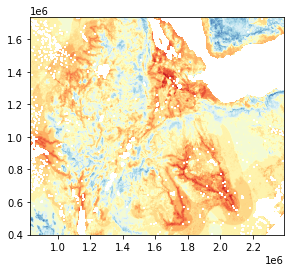

In [50]:
#visualising unweighted risk raster
show(risk_raster, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

In [51]:
#calculating weighted risk raster
weighted_risk = slope_reclass * 0.25 + riv_reclass * 0.35 + elev_reclass * 0.15 + land_reclass * 0.25

In [52]:
#checking weighted risk raster
weighted_risk

array([[2.95, 2.95, 2.95, ..., 3.15, 2.65, 3.15],
       [2.95, 2.95, 2.95, ..., 3.15, 3.15, 2.9 ],
       [2.95, 3.45, 2.95, ..., 2.4 , 2.9 , 2.9 ],
       ...,
       [2.8 , 2.8 , 2.8 , ...,  nan,  nan,  nan],
       [2.8 , 2.8 , 2.8 , ...,  nan,  nan,  nan],
       [2.8 , 2.8 , 2.8 , ...,  nan,  nan,  nan]])

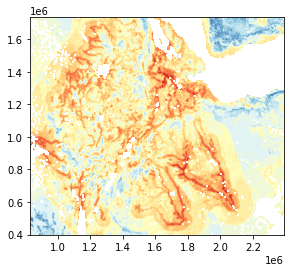

In [53]:
#visualising weighted risk raster
show(weighted_risk, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Mask the Risk Rasters (10 pts)

Because the rivers shapefile was confined to the boundaries of Ethiopia and the elevation DEM contained some missing data outside of the boundaries of Ethiopia, our risk rasters only have accurate values within the boundaries of Ethiopia. Hence we should mask the risk rasters to the boundaries of Ethiopia by marking all cells outside of Ethiopia as `np.NaN` to denote no data. This can be done as follows:

1. Use [`gpd.read_file()`](https://geopandas.org/docs/reference/api/geopandas.read_file.html#geopandas.read_file) to read in the boundaries of Ethiopia.
2. Use [`features.rasterize()`](https://rasterio.readthedocs.io/en/latest/api/rasterio.features.html#rasterio.features.rasterize) from RasterIO to convert the Ethiopia shapefile into a binary raster.
3. Use [boolean indexing](https://numpy.org/doc/stable/reference/arrays.indexing.html#boolean-array-indexing) to replace all cells in the risk rasters that are not within Ethiopia with `np.NaN`.

Once you have masked the risk rasters, visualize them again using the appropriate `transform` and the `"RdYlBu_r"` (reversed red-yellow-blue) colormap.

In [54]:
#Using gpd.read_file() to read in the boundaries of Ethiopia.
ethiopia = gpd.read_file('./data/boundaries/ethiopia.shp')

In [55]:
#Using features.rasterize() from RasterIO to convert the Ethiopia shapefile into a binary raster.
ethiopia_raster = features.rasterize(ethiopia['geometry'], out_shape=ele_shape, fill=1, transform=ele_transform, default_value=0)

In [56]:
#Using boolean indexing to replace all cells in the risk rasters that are not within Ethiopia with np.NaN.
ethiopia_reclass = np.full(ele_shape, np.NaN)

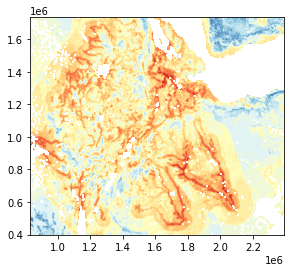

In [58]:
#visualising weighted risk raster
show(weighted_risk, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

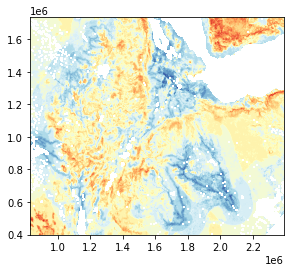

In [59]:
#visualising unweighted risk raster
show(risk_raster, transform=ele_transform, cmap='RdYlBu_r')
plt.show()

## Extra Credit: Calculate Zonal Statistics (20 pts)

Determine the administrative zone with the highest risk as follows:

1. Use [`gpd.read_file()`](https://geopandas.org/docs/reference/api/geopandas.read_file.html#geopandas.read_file) to read in the administrative zones shapefile.
2. Visualize the administrative zone boundaries on top of the masked weighted risk raster.
3. Use the [`rasterstats`](https://pythonhosted.org/rasterstats/index.html) package to calculate the average weighted risk for each administrative zone.
4. Add the calculated average weighted risk values to the administrative zones GeoDataFrame.
5. Sort the administrative zones GeoDataFrame on the average weighted risk values and report the zone with the highest risk.
5. Visualize the administrative zones on a red-yellow-blue choropleth map where higher risk zones are colored red and lower risk zones are colored blue.